# Advanced Secondary Flare Detection

We covered the basics of using flare_finder to detect flares in TESS ligthcurves and how to tune TOFFEE to find desired primary flares. In the end of the flare_finder tutorial we saw a lightcurve labeling flares in red and blue. Here we'll be focusing on those blue flares, the secondary flares. The specific goal of TOFFEE is to be capable of finding secondary flare and thus contains variables to find these buried signals in lightcurves.

In this lightcurve we will cover four more arguments used in flare_finder:

**visualize_fit**: boolean value determining whether or not flare_finder produces plots on all the model fits applied to the rises and decays of the flares as well as searching for secondaries in the residuals.

**sec_flare_std**: a float variable that controls how big a signal in the residual of a flare model needs to be to register as a detection. sec_flare_std is the scalar multiple to the global spread, σ, to dictate how bright a series of points must be for classification as a secondary flare.

**fit_twice**: boolean value. If True TOFFEE will attempt to refit the decay of the flare

**sec_marg_rate**:  Only matters if fit_twice == True. Float variable controlling how TOFFEE defines points in the residual as potentially being part of the secondary flare that didn't rise enough to rise above the threshold of detection.

**fit_multiple_secs**: boolean value. If True TOFFEE will search in the residual for multiple bright epochs as tertiary or other high order flares in the decays of primary flares. If False TOFFEE will stop at one secondary flare.

In [1]:
import toffee
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#for plotting and coloring flares
#This is actually a pretty useful function for plotting all the flares in a lightcurve, feel free to use it

def flare_color(flare_results):

    flare_peak_times, flare_start_times, flare_end_times, flare_amps, flare_type, num_points_in_flare = (flare_results[0],
                                                                                                     flare_results[1],
                                                                                                     flare_results[2],
                                                                                                     flare_results[3],
                                                                                                     flare_results[5],
                                                                                                     flare_results[6])
    ###########Let's find the points belonging to the flares###########
    
    #For primaries
    #array holding the times of the flare points
    times_of_primary_flares = np.array([])
    #array holding associated fluxes
    fluxes_of_primary_flares = np.array([])
    #array holding peak times
    peak_time_of_primary = np.array([])
    #array holding peak flux
    peak_flux_of_primary = np.array([])
    
    #array holding the times of the flare points
    times_of_secondary_flares = np.array([])
    #array holding associated fluxes
    fluxes_of_secondary_flares = np.array([])
    #array holding peak times
    peak_time_of_secondary = np.array([])
    #array holding peak flux
    peak_flux_of_secondary = np.array([])
    
    
    
    
    
    #iterate through the flares and find the relevant times
    
    for i in range(len(flare_start_times)):
    
        start = flare_start_times[i]
        end = flare_end_times[i]
    
        #find indices of flux points between these values
        flare_flux_points = np.where((time >= start) & (time <= end))[0]
    
        #and log those times in the flare
        flare_times = time[flare_flux_points]
    
        #and log those fluxes
        flare_fluxes = flux[flare_flux_points]
    
        #find the peak flux
        peak_flux = np.max(flare_fluxes)
    
        #and associated time
        peak_time = flare_times[np.argmax(flare_fluxes)]
        
        #sort depending on type
        if (flare_type[i] == 'primary') or (flare_type[i] == 'primary_failed_dbl_fit'):
            #add to the list
            times_of_primary_flares = np.append(times_of_primary_flares, flare_times)
            fluxes_of_primary_flares = np.append(fluxes_of_primary_flares, flare_fluxes)
            peak_flux_of_primary = np.append(peak_flux_of_primary, peak_flux)
            peak_time_of_primary = np.append(peak_time_of_primary, peak_time)
            
        else:
            #add to the list
            times_of_secondary_flares = np.append(times_of_secondary_flares, flare_times)
            fluxes_of_secondary_flares = np.append(fluxes_of_secondary_flares, flare_fluxes)
            peak_flux_of_secondary = np.append(peak_flux_of_secondary, peak_flux)
            peak_time_of_secondary = np.append(peak_time_of_secondary, peak_time)


    return (times_of_primary_flares, fluxes_of_primary_flares, peak_flux_of_primary, peak_time_of_primary,
            times_of_secondary_flares, fluxes_of_secondary_flares, peak_flux_of_secondary, peak_time_of_secondary)

# Bring in Real Data

We'll focus on using real data containing secondary flares to show how TOFFEE works in practice finding secondary flares.

Let's bring in a real lightcurve and zoom in on the biggest spike

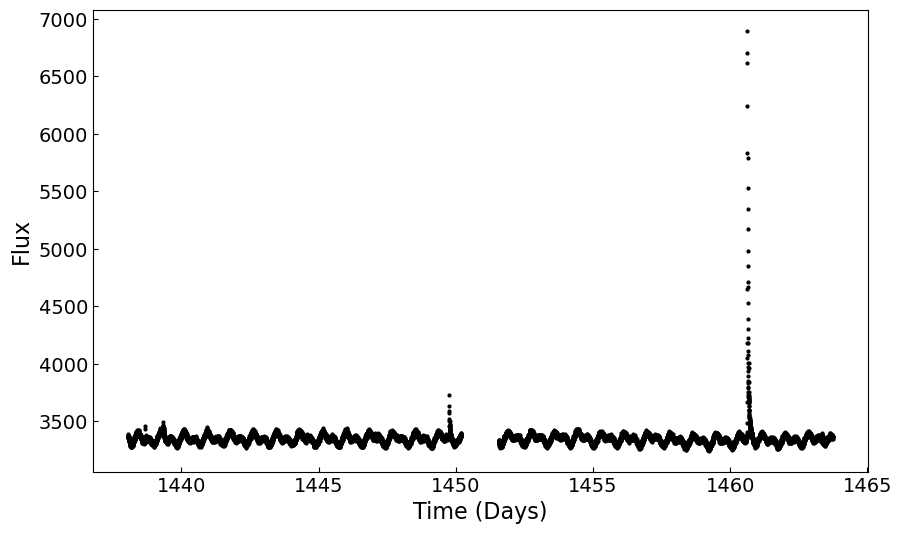

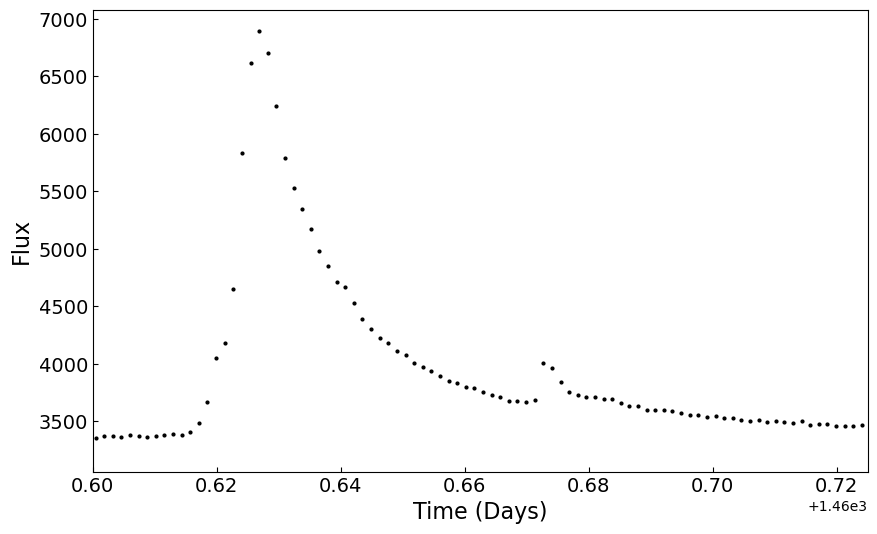

In [3]:
TIC_number = 100481123
TESS_sector = 5

lc = lk.search_lightcurve('TIC ' + str(TIC_number), sector = TESS_sector, mission = 'TESS', author = 'SPOC', exptime = 120).download()

time = lc.time.value
#unmask flux, quality, and flux error
flux = np.array(lc.flux.value)
quality = np.array(lc.quality.value)
flux_err = np.array(lc.flux_err.value)

#plot raw lightcurve

plt.figure(figsize = (10,6))
plt.scatter(time, flux, s = 4, color = 'black')
plt.xlabel('Time (Days)', fontsize = 16)
plt.ylabel('Flux', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()

#plot zoom-in on giant spike

plt.figure(figsize = (10,6))
plt.scatter(time, flux, s = 4, color = 'black')
plt.xlabel('Time (Days)', fontsize = 16)
plt.ylabel('Flux', fontsize = 16)
plt.xlim(1460.6, 1460.725)
plt.tick_params(direction = 'in', labelsize = 14)

Here, in the raw lightcurve, we see an event where there's a very large flare where there is an additional signal hiding in the decay. We'll see how TOFFEE works to deduce that as an additional flare signal.

# Basic Secondary Detection

For detected flare event TOFFEE fits a model to represent the rise and the decay of the flare. For primary flares with at least 6 points in the rise (points associated with the flare to the left of the peak) TOFFEE either fits a quadratic or a guassian rise (with the guassian rise being the recommended setting) the cadences. For primary flares with at least 6 points in the decay TOFFEE fits a double exponential to the cadences. 

If there are a number of cadences that act out of the expected behavior of the model and are exceptionally bright then TOFFEE concludes there is another, smaller flare overlapping with the primary flare. We call these flares secondary flares because they're found second via modeling the primary flares. They don't necessarily occur AFTER the primary flare (though they often do) the only true definition is that their peak flux is smaller than the primary flare.

The way TOFFEE defines a period in the rise or decay as being exceptionally bright is from the residual of the fit, the value of the fluxes of the cadences minus the value of the fits at the same times as the cadences. This tells us how much brighter or dimmer the cadences are relative to the expected behvior from the model. If there are three consecutive points with residuals greater than a threshold given by the global spread of the points then there is a secondary flare identified. It's very similar to primary flare detection in this way, with the signal now being saught in the residual. For TOFFEE the threshold for secondary flare detection, given by **sec_flare_std** is independent of the threshold used for primary flare detection is set to 2.0 as default. This means there must be three consecutive points in the residual with values greater than 2σ of the global spread of the points.

## **NOTE**

For very large flares with amplitudes greater than 1 the internal complexities of the flare that deviate from the double exponential decay start to register as large signals. To avoid ambiguity between these deviations with a flare and actual secondaries the threshold is automatically set to 10σ to only find sure-fire signals. Look at TIC 114029415 Sector 42 for a cool example.

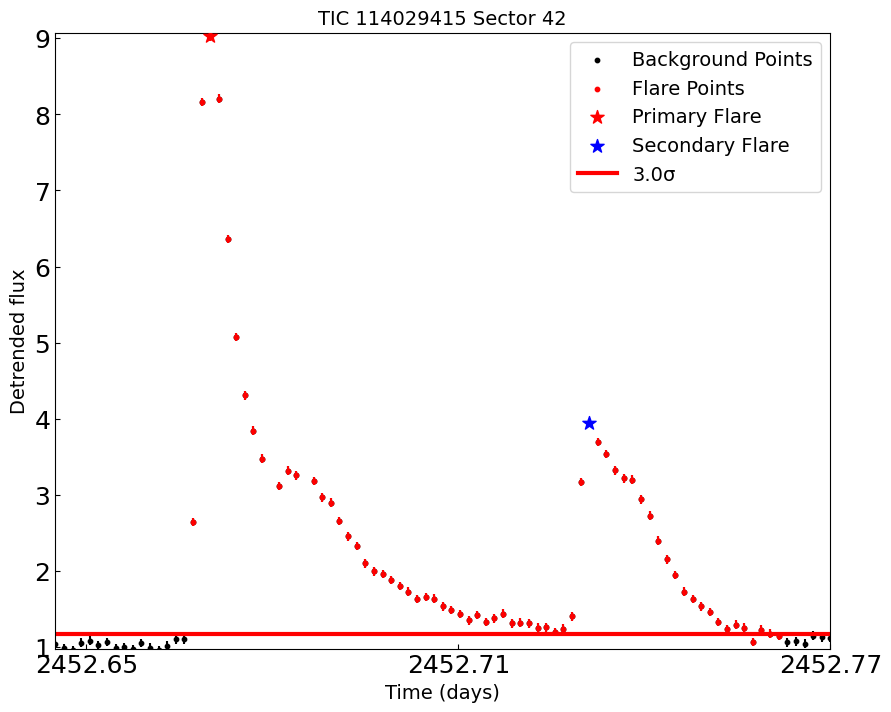

Let's see this in action with the previously mentioned lightcurve.

For this we can use another in-built functionality of TOFFEE, **visualize_fit**.

visualize_fit will make separate plots for all the flares for which a model was fit to the rise or decay. It will plot the primary flare with the fitted function over plotted, then it will plot the residual with the threshold for detection drawn as a horizontal line, and a plot with the points identifies as being a part of the secondary flare colored and labeled if one was found.

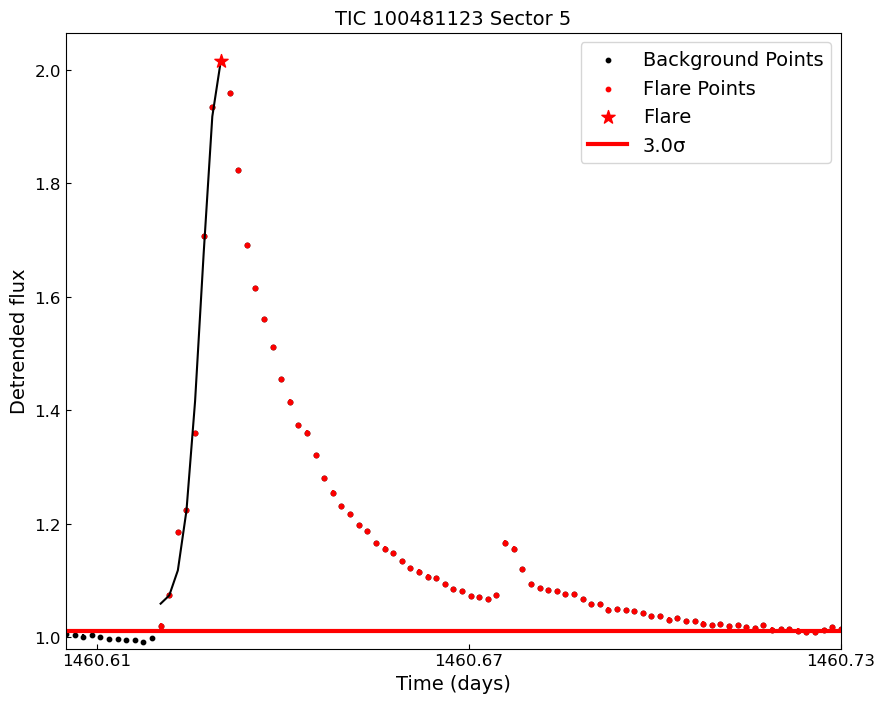

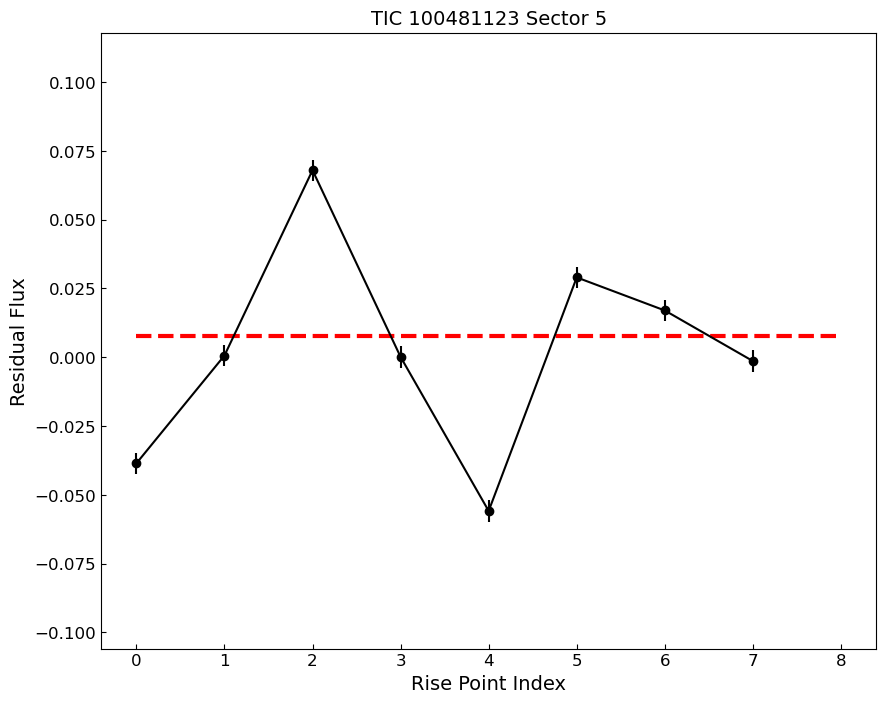

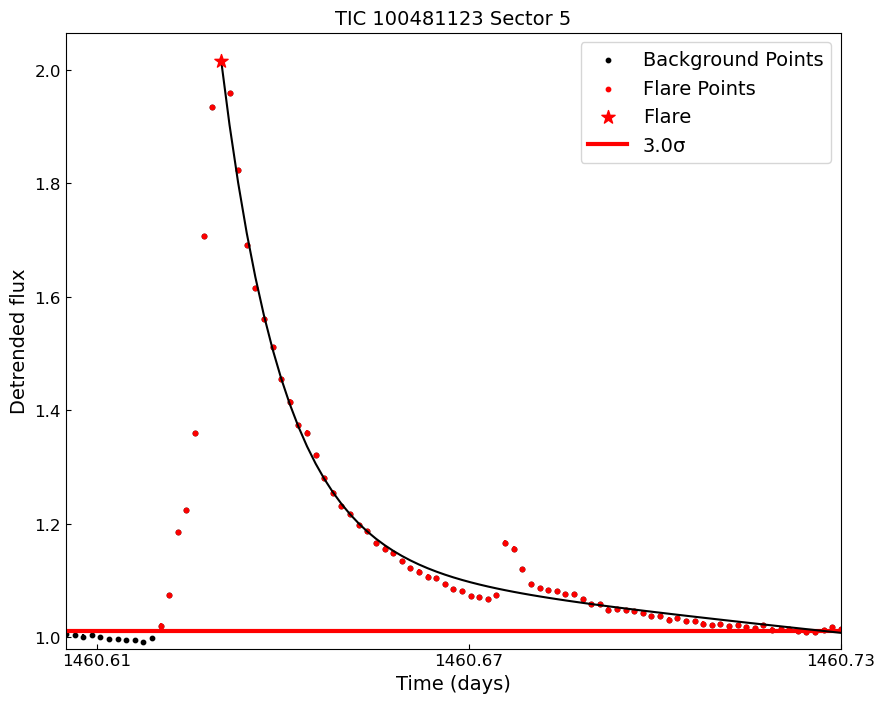

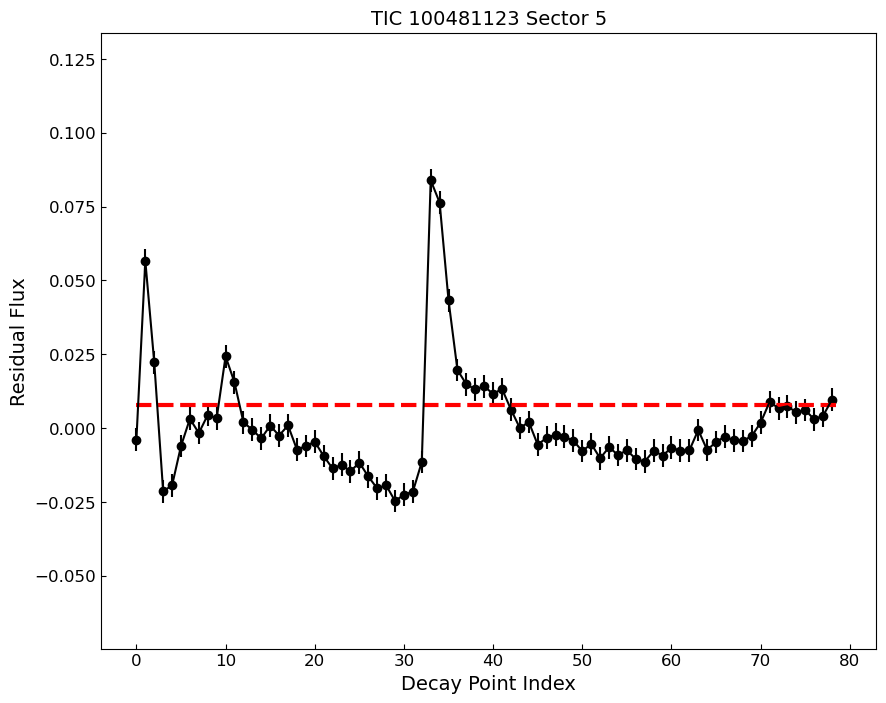

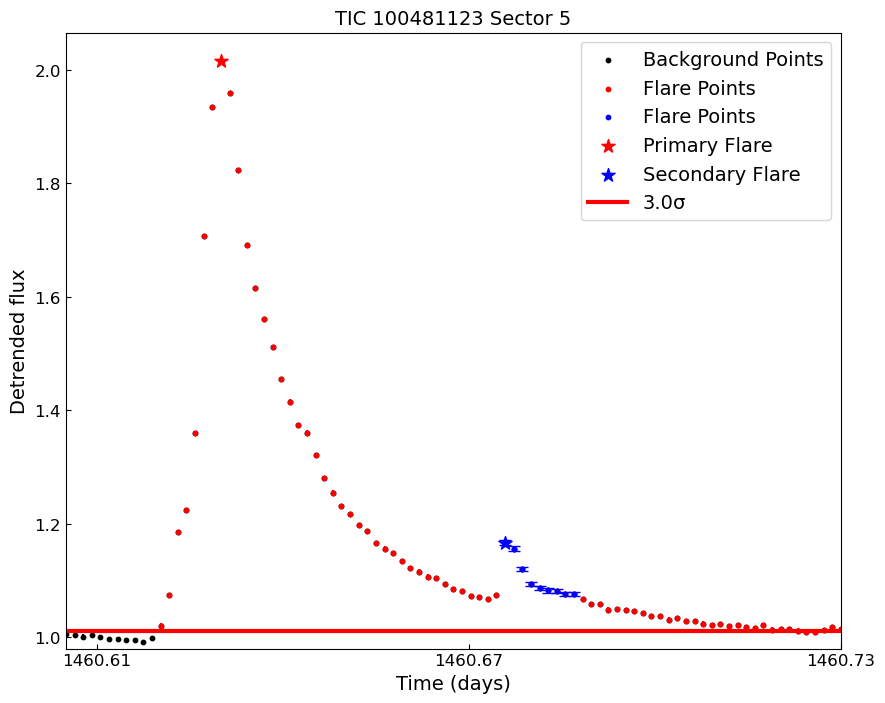

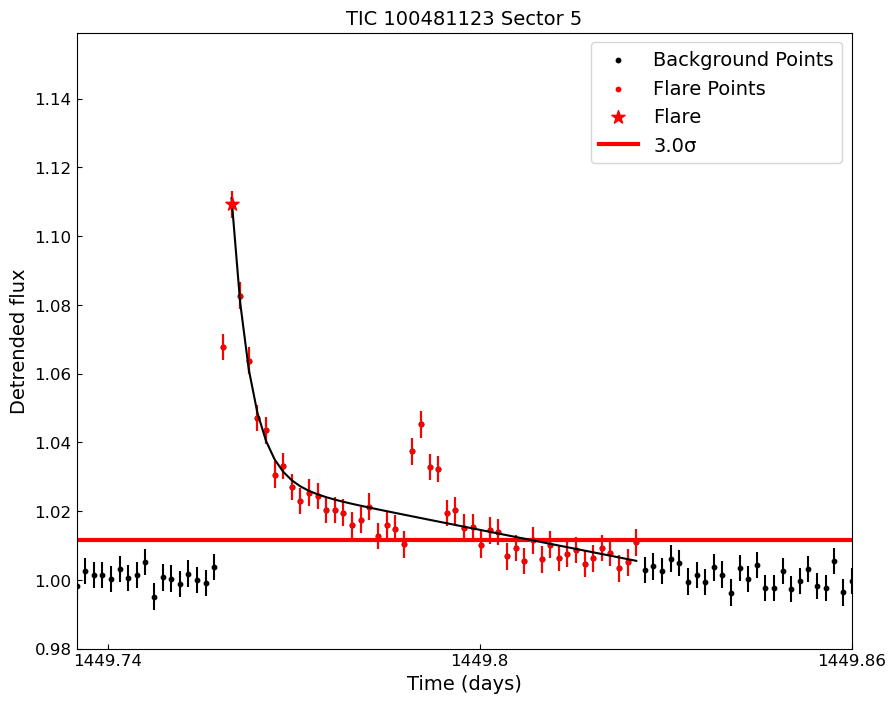

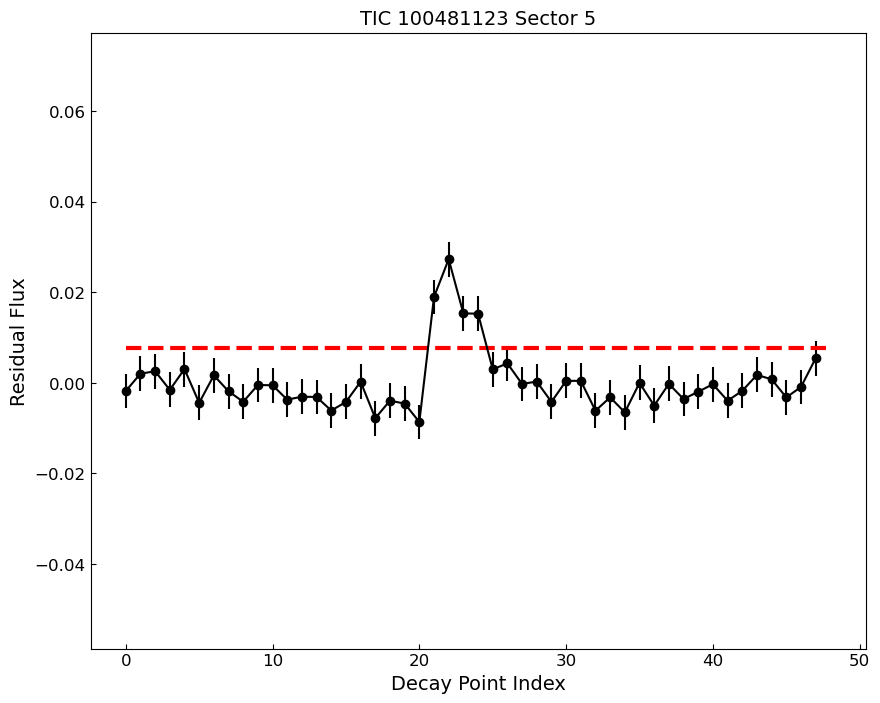

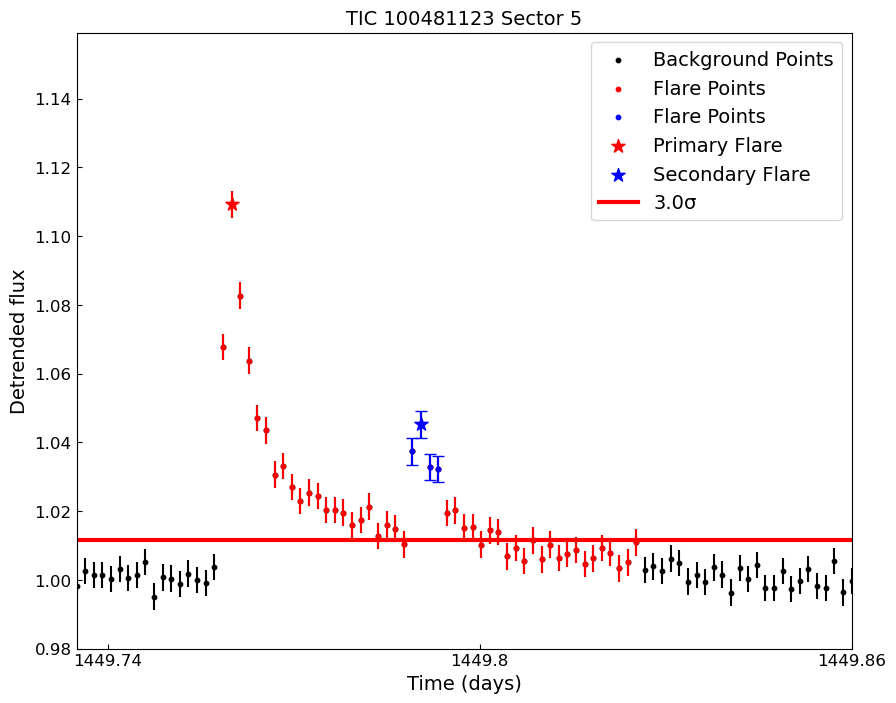

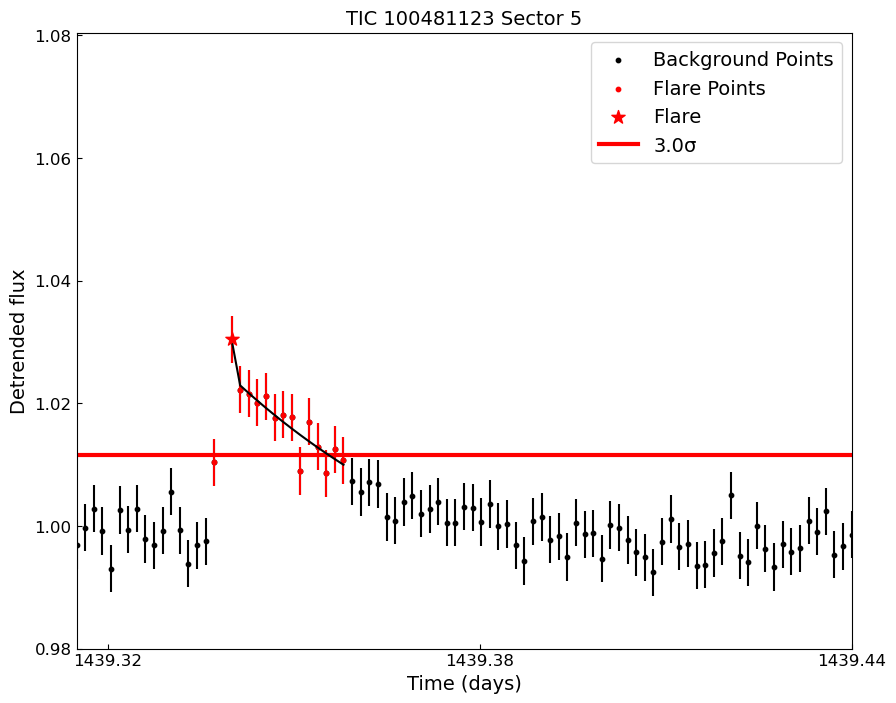

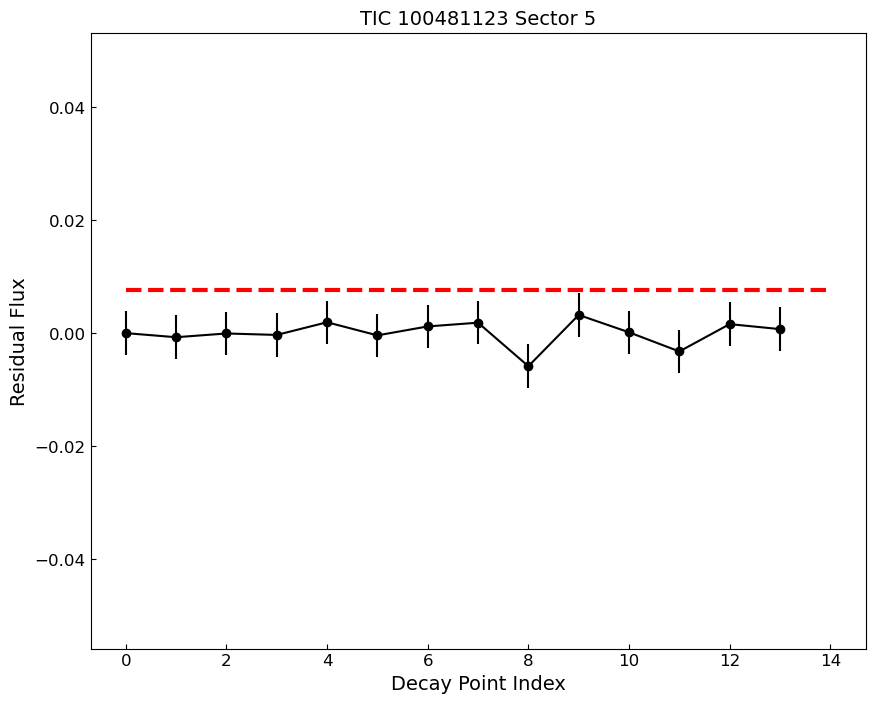

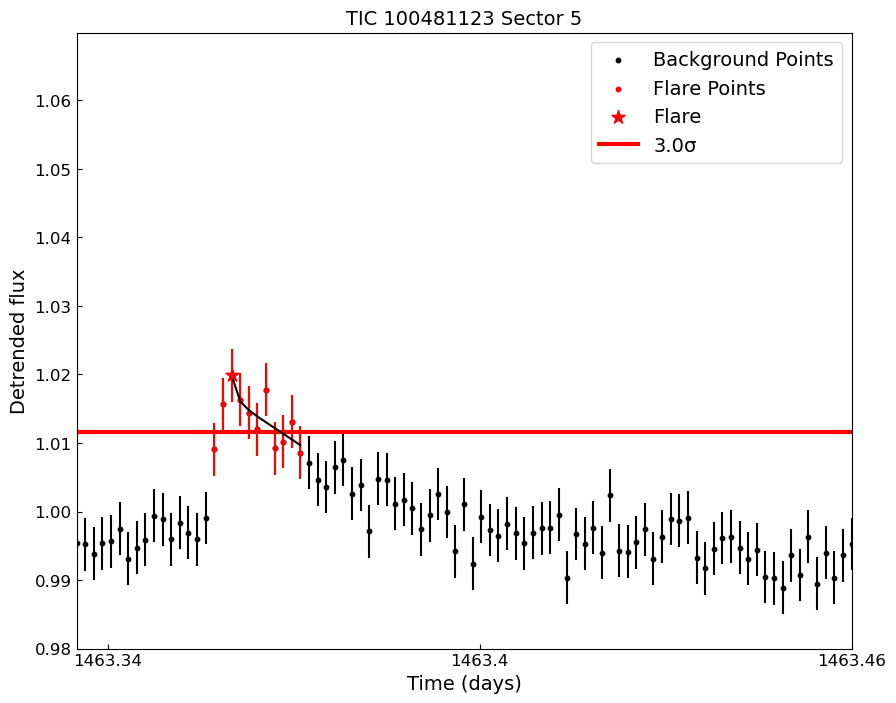

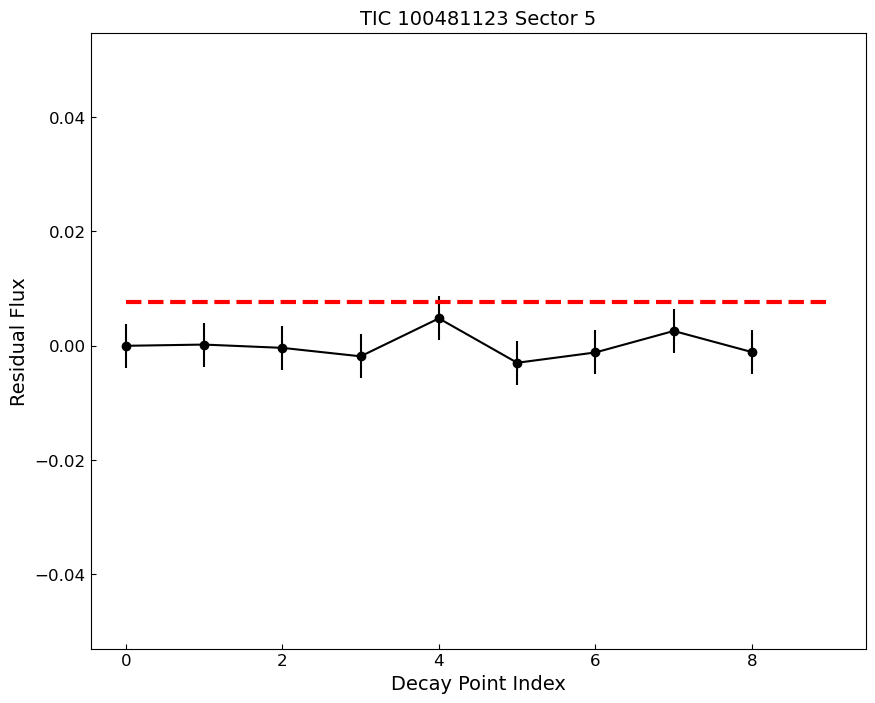

(array([1438.68750098, 1439.3361333 , 1449.76137866, 1449.79193465,
        1460.62680897, 1460.67264257, 1463.35737317]),
 array([1438.68750098, 1439.33335544, 1449.75998975, 1449.79054574,
        1460.61708669, 1460.67264257, 1463.35459539]),
 array([1438.69305671, 1439.35418944, 1449.82665735, 1449.79471246,
        1460.73514293, 1460.68375375, 1463.36848428]),
 array([0.03696789, 0.03044903, 0.10921931, 0.02727595, 1.01584541,
        0.08391661, 0.01989501]),
 array([   8.79191719,   31.19543096,  129.85126921,    7.16195429,
        1734.56768511,   28.95445013,   16.4881115 ]),
 array(['primary', 'primary', 'primary', 'secondary', 'primary',
        'secondary', 'primary'], dtype='<U9'),
 array([ 4, 14, 48,  1, 85,  1, 10]),
 array([ 3, 11, 31,  1, 79,  1,  7]),
 array([  9.5989961 ,   7.90632484,  28.35963125,   7.08240908,
        263.77204445,  21.78959085,   5.16589203]))

In [4]:
toffee.flare_finder(time, flux, flux_err, quality, detrend = True, consecutive = False, sec_flare_std = 2.0,
                    visualize_fit = True, TIC_number = 100481123, TESS_sector = 5)

### Analysis

We can see the first two primary flares identified by TOFFEE, the two largest primary flares, both have secondaries. In the residuals of the decays of these two flares there are at least three points with values above 2σ. However the fits for the remaining two flares show no such bright epochs in the decays of the flares and there is nothing irregular in the rise of the two large flares.

## Change **sec_flare_std** to a value of 5.0

If we change **sec_flare_std** to a value of 5.0 we will get a different result. I won't rerun the code to limit the length of the notebook but the important outputs come from the fit of the decay of the two largest flares. Let's look at those plots from **visualize_fits**

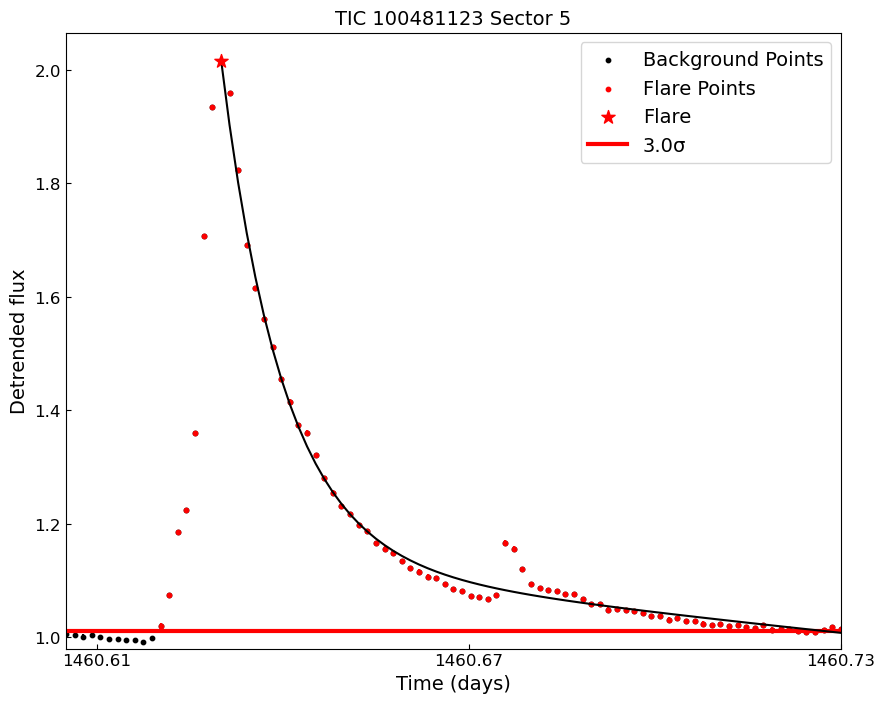

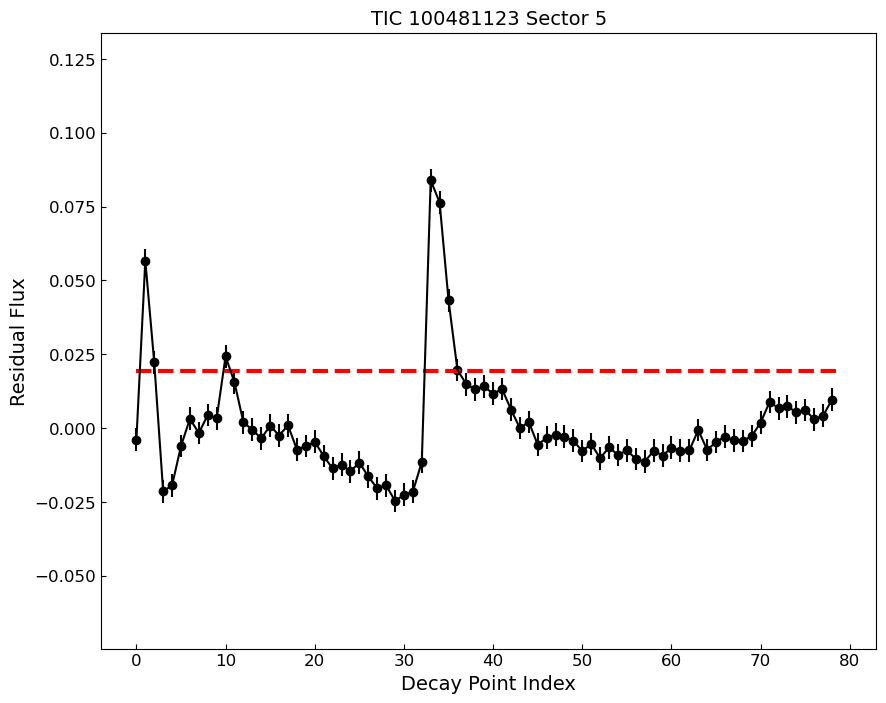

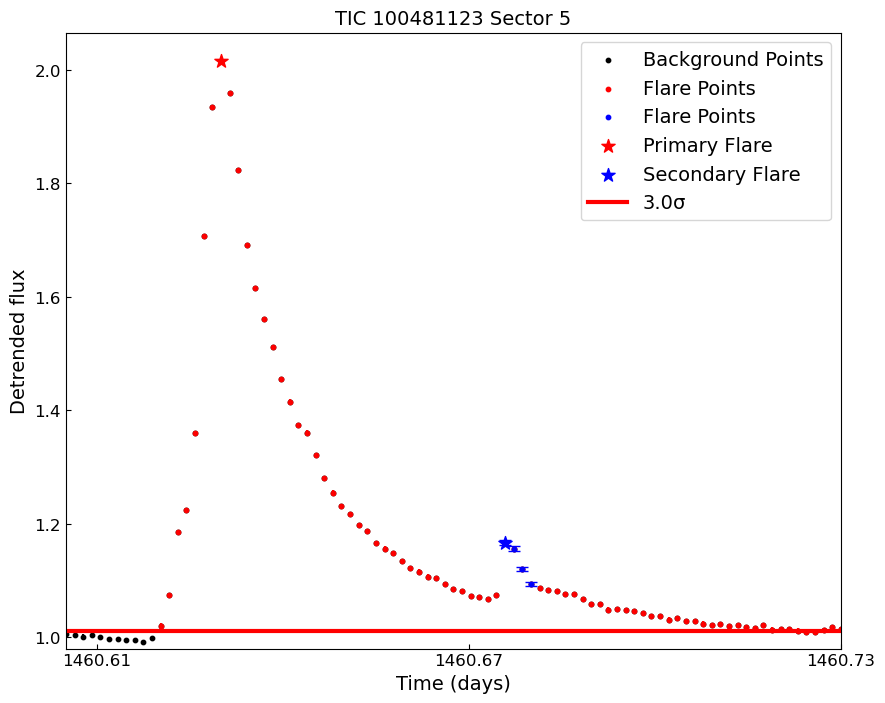

### Analysis

The secondary in the decay of the flare is still found, however fewer points are labeled in blue because there are fewer points above the threshold of secondary detection.

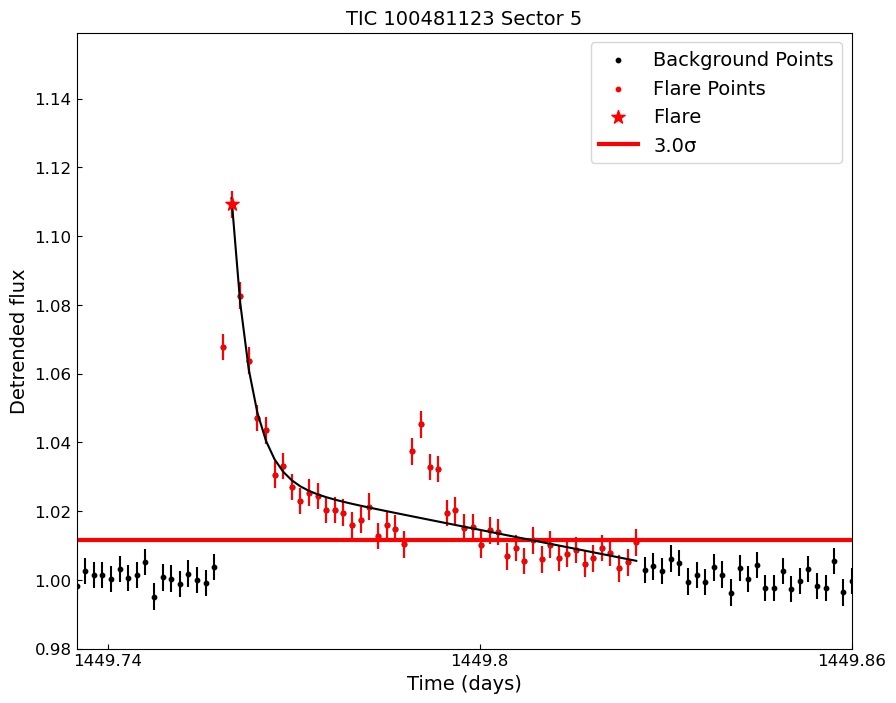

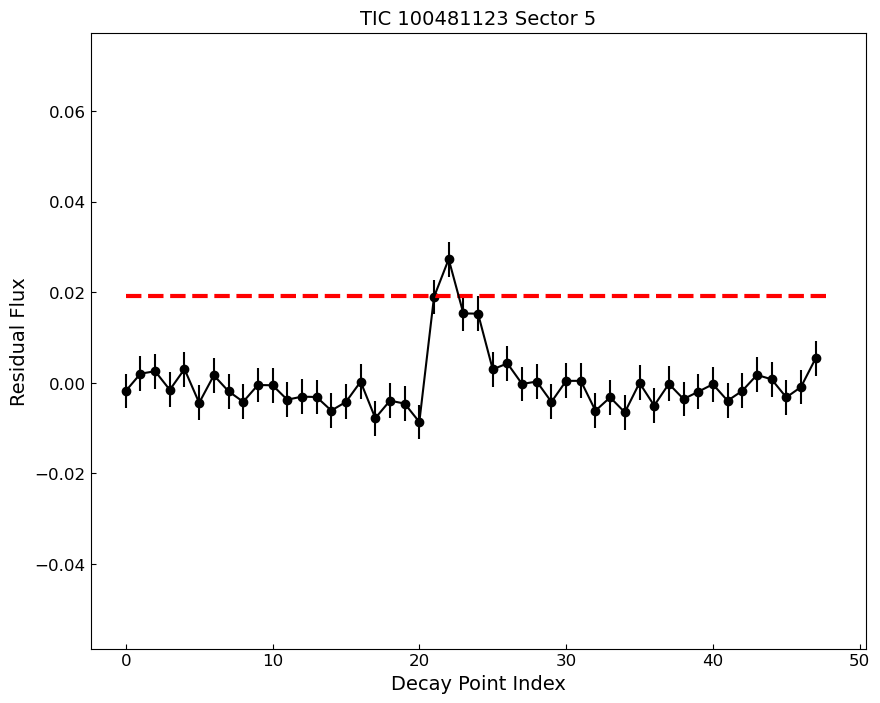

### Analysis

The secondary in the decay is no longer found. The higher threshold for secondary flare detection is too high for three consecutive points to be above 5σ.

## Secondary in the rise of a flare

Just as an example let's look at a lightcurve in which there is a secondary in the rise of a flare. They're pretty rare.

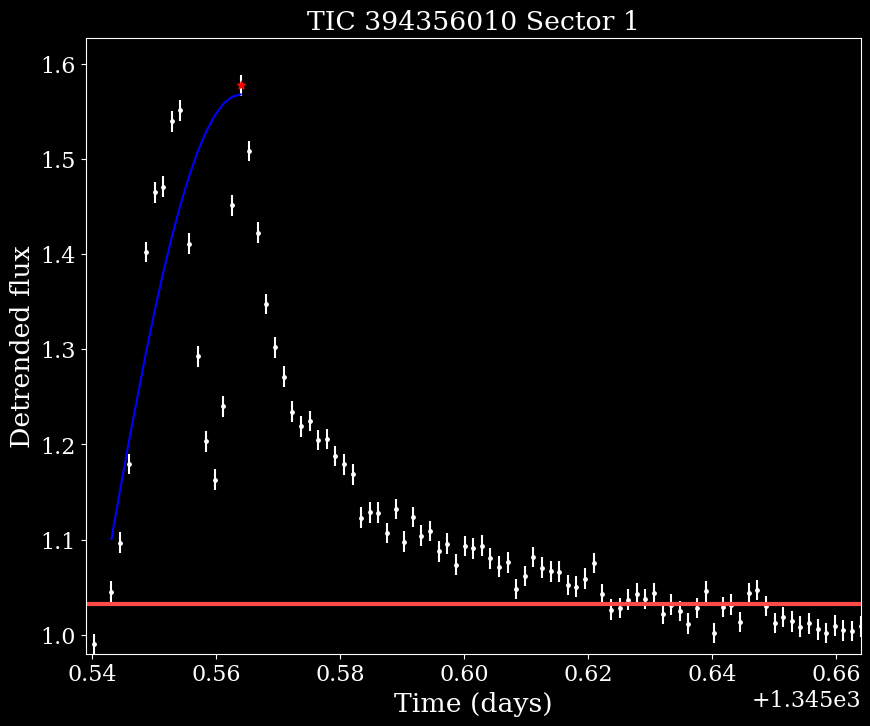

# Fit_Twice

It's important to note an effect of a secondary flare on the ability to fit a function to the decay. If there are cadences that are much brighter than expected from the model it may effect the values of the best fit function such that it lifts the tail a little bit. This lowers the value of the residual compared to a fit that would ignore these points associated with the secondary and only traces the cadences soley associated to the primary. This can have a knock-on effect of missing some secondaries.

To get around this TOFFEE includes a feature called **fit_twice**. If **fit_twice** is set to true TOFFEE will trim out some points that were deemed to have risen the tail of the decay and refit to note it's affect on the residuals. Which points are determined to have effected the fit and thus are taken out are determined by the **sec_marg_rate** argument. It works similar to the **prim_marg_rate** from earlier. **sec_marg_rate** is a float argument where the points in the residual with values of sec_marg_rate * sec_flare_std * σ are deemed to have affected the quality of the fit. The default value of **sec_marg_rate**=0.75 alongside **sec_flare_std**=2.0 means that values in the residual with values of 1.5σ or higher are trimmed.

After this step the double exponential is re-fit onto the decay to lower it to a more representative value for the primary's decay. The trimmed points are then added back on and the residuals are re-examined. If the new residuals have three consecutive points above the threshold set by **sec_flare_std** then a new flare is added. These flares are labeled as "secondary_second_try" in the flare type. If there is still no epoch in the decay then we note this by labeling the primary flare as type "primary_dbl_fit_failed". The reason for this is to monitor the relative success of re-fitting to find flares. For Pratt et al 2025 only 25% of attempted re-fits found extra flares. Changing **sec_flare_std** will change this rate such that lowering **sec_flare_std** will raise the rate at which we find secondaries as we trim out more bright points pushing the tail of the decay down.

If visualize_flare == True then TOFFEE will also create plot of the flare event with both fits overplotted for comparison.

Let's bring in a real lightcurve and zoom in on a certain epoch after detrending.

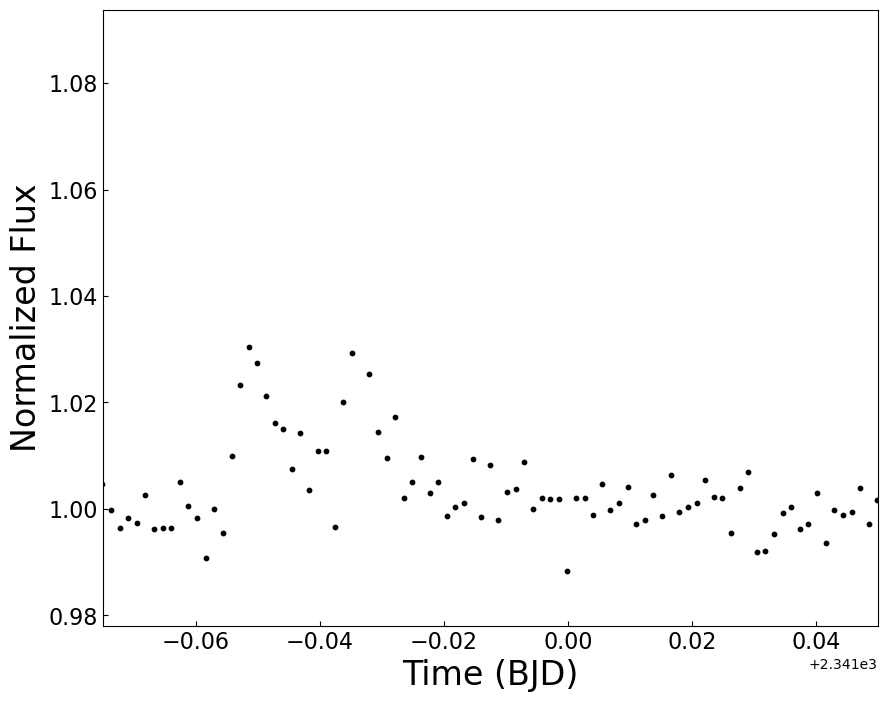

In [5]:
TIC_number = 452591471
TESS_sector = 38

lc = lk.search_lightcurve('TIC ' + str(TIC_number), sector = TESS_sector, mission = 'TESS', author = 'SPOC', exptime = 120).download()

time = lc.time.value
#unmask flux, quality, and flux error
flux = np.array(lc.flux.value)
quality = np.array(lc.quality.value)
flux_err = np.array(lc.flux_err.value)


t_curve, quadratic, wotan_fit, flatt, periodic = toffee.flatten(time, flux, flux_err, plot_results=False,
                                              short_window=0.25, periodogram=[0.01, 10])

flatt_flux = flatt[0]

#Third plot: Show the flattened lightcurve with the flares found and colored in
plt.figure(figsize = (10,8))
plt.scatter(t_curve, flatt_flux, s = 10, color = 'black')
plt.xlabel('Time (BJD)', fontsize = 24)
plt.ylabel(r'Normalized Flux', fontsize = 24)
#plt.ylim(0.9, 1.25)
plt.xlim(2340.925, 2341.05)
plt.tick_params(direction = 'in', labelsize = 16)
plt.show()

## Two Close Peaks

Here we see the signatures of two flares very closely separated. There aren't enough cadences between the flares for TOFFEE to distinguish them as two events on its own. It will be identified as one continuous epoch. The smaller peak on the right must be found as a secondary.


Let's run flare_finder again, with **sec_marg_rate** set to a value of 0.6. We'll cut to the results as it pertains to this specific flare.

In [8]:
toffee.flare_finder(time, flux, flux_err, quality, detrend = True, consecutive = False, sec_flare_std = 2.0,
                    fit_twice = True, sec_marg_rate = 0.6, visualize_fit = False, TIC_number = 452591471, TESS_sector = 38)

(array([2340.22770552, 2340.94853849, 2340.96520514, 2344.6540867 ,
        2346.08463685, 2347.53879741, 2351.68461129, 2355.38180662,
        2356.39846437, 2357.15123513, 2358.36233417, 2358.97899432]),
 array([2340.22492775, 2340.94576071, 2340.96381626, 2344.65130893,
        2346.07908132, 2347.53879741, 2351.68183353, 2355.38041774,
        2356.3970755 , 2357.15123513, 2358.3609453 , 2358.97760545]),
 array([2340.23464997, 2340.97631625, 2340.96798292, 2344.70825319,
        2346.10685898, 2347.54574183, 2351.68738905, 2355.38736213,
        2356.40679763, 2357.15956838, 2358.36650079, 2359.00260518]),
 array([0.03559561, 0.03044116, 0.02069736, 0.08128353, 0.02375063,
        0.02476144, 0.02301523, 0.03630855, 0.05933893, 0.03959087,
        0.03813392, 0.08861506]),
 array([ 19.09517411,  40.70198189,   4.18369461, 115.2478565 ,
         39.76381814,   9.45370339,   8.09418238,  13.70669752,
         27.89501816,  14.89739241,  14.38878618,  42.86891754]),
 array(['primary',

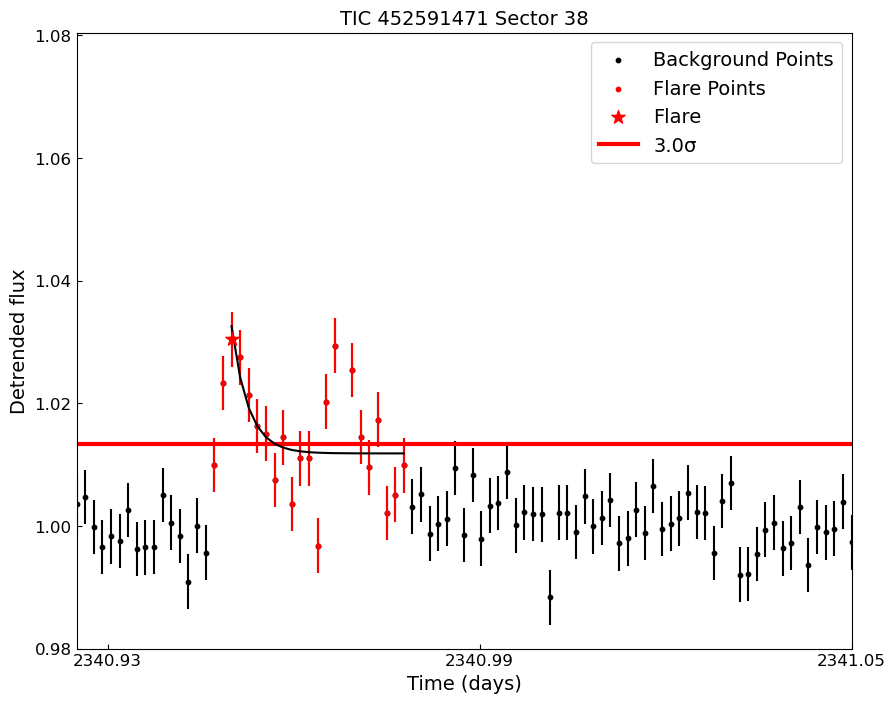


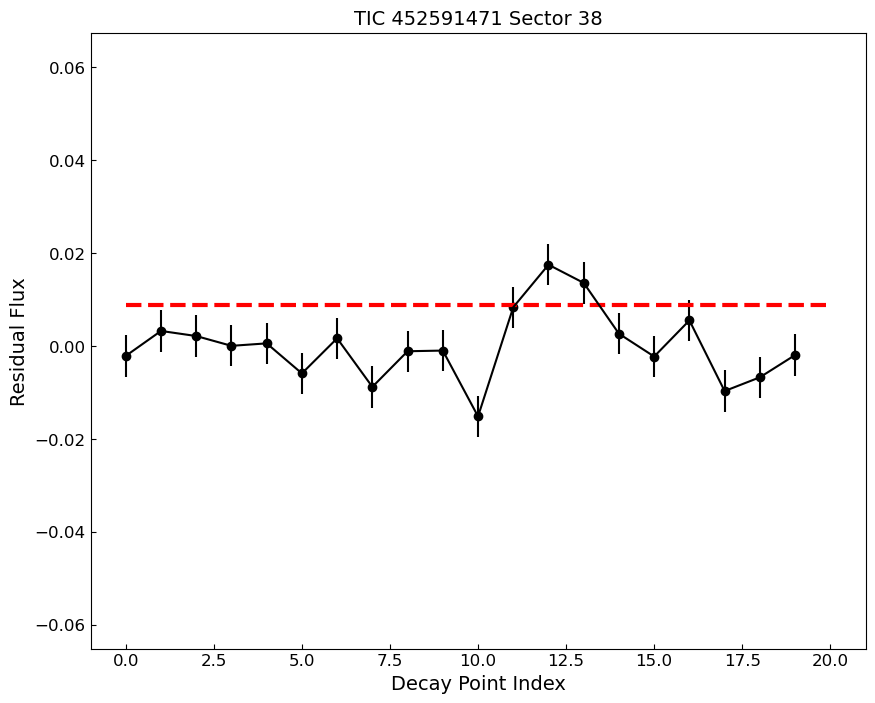


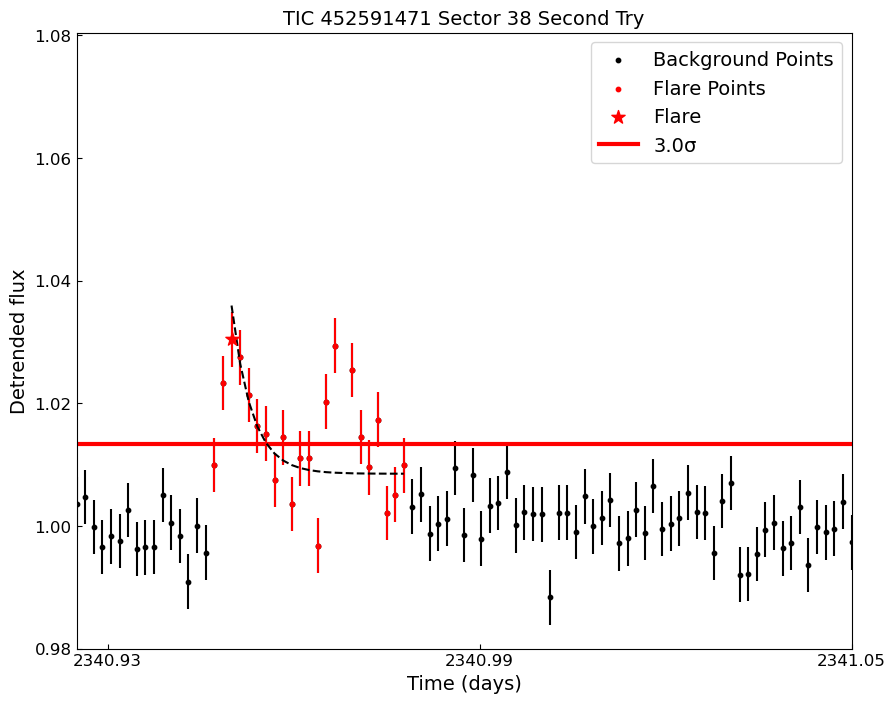


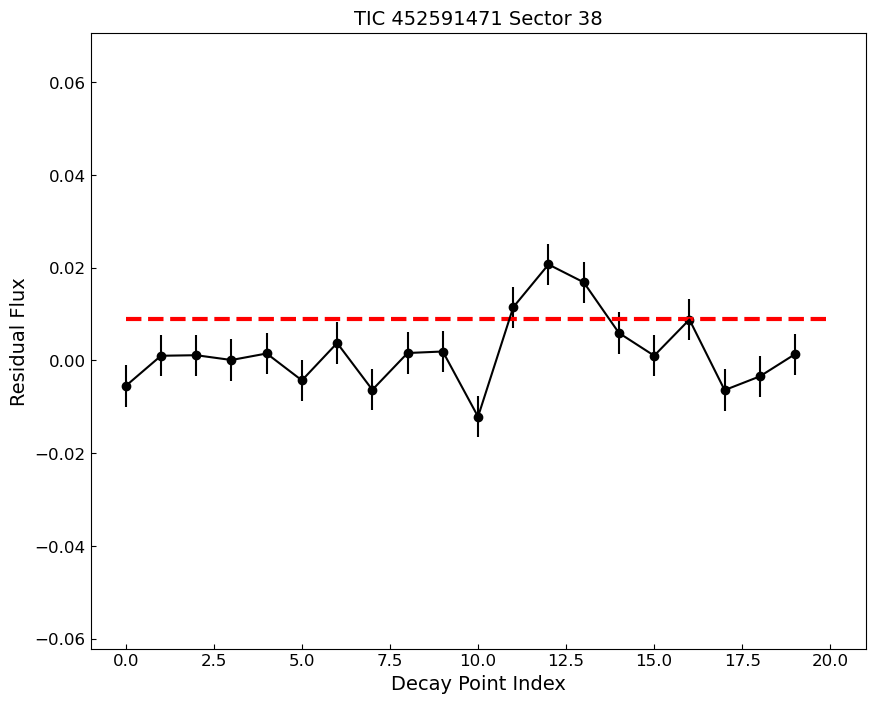


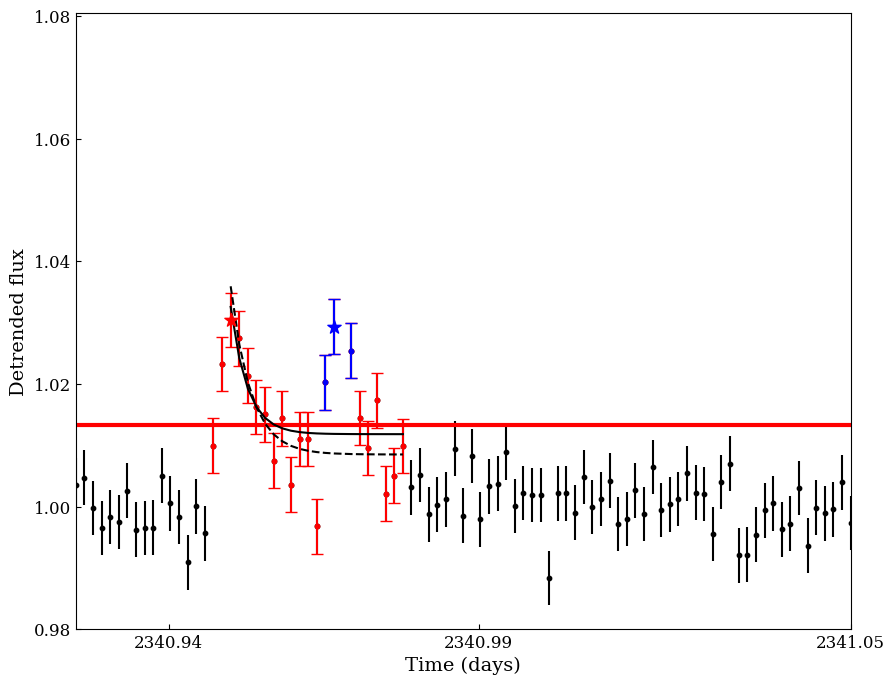

## Analysis

We can see that there is one cadence marginally below the threshold preventing the secondary flare as being recognized. However, once we trim out the brighter points that affected the best-fit double exponential decay and re-attempt it the peak is more pronounced in the residual. The secondary is identified! The final plot overplots the original fit in the solid black curve and the re-fit in the dashed curve.

# Beyond Secondaries

It is also possible that there are multiple flares in the decay of a primary. Turning on the **fit_multiple_secs** functionality tells TOFFEE to look for said events. Tertiary and other high order flares are found in the decay and labeled.

Let's make a synthetic lightcurve with one flaring event with two extra flares in the secondary and see how TOFFEE finds both in the residual.

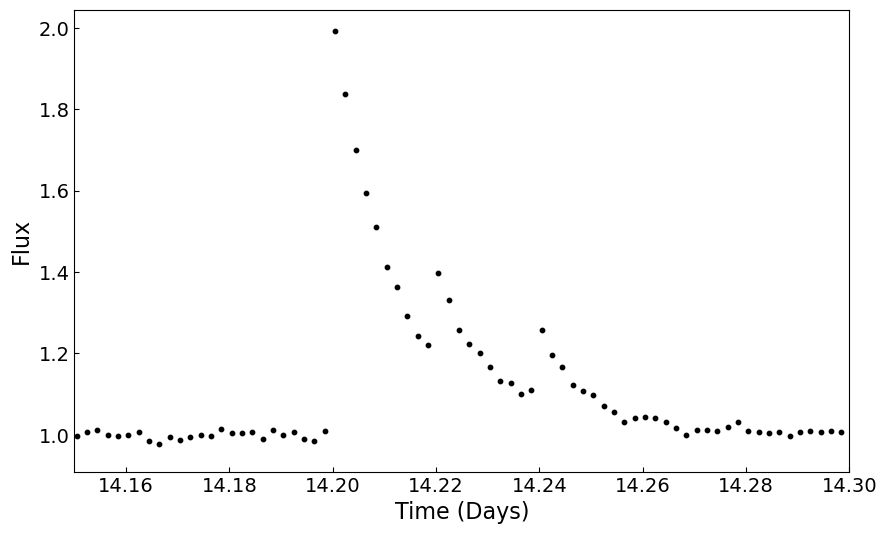

In [25]:
np.random.seed(42)

#define shape for the decay of a flare given from double exponential decay
def dbl_exp_decay(x, start_time, alpha_0, beta_0, alpha_1, beta_1, C):

    return (alpha_0 * np.exp(- beta_0 * (x - start_time)) +
            alpha_1 * np.exp(- beta_1 * (x - start_time))  + C)
    
#Function that creates simple lightcurve and tests various aspects
#of TOFFEE to detect them


#Simple, detrended lightcurve

time = np.linspace(10, 30, 10000) #just some time labels for TOFFEE

flux = 1 + np.random.normal(0, 10**-2, 10000) #Note we set the spread of the points to 10**-2

flux_err = np.full(10000, 10**-2) #same as spread of points

quality = np.full(10000, 0) #state all qualities are good

#return to that flare we added
flux[2100:2150] = (dbl_exp_decay(time[2100:2150], time[2100], 0.5, 75, 0.5, 100, 0) +
                   np.random.normal(0, 10**-2, 50) + 1)

#and the smaller one immediately to the right
flux[2110:2150] = flux[2110:2150] + dbl_exp_decay(time[2110:2150], time[2110], 0.12, 50, 0.09, 180, 0)

#and then another small one to the right
flux[2120:2150] = flux[2120:2150] + dbl_exp_decay(time[2120:2150], time[2120], 0.08, 100, 0.08, 200, 0)


plt.figure(figsize = (10,6))
plt.scatter(time, flux, s = 10, color = 'black')
plt.xlim(14.15, 14.3)
plt.xlabel('Time (Days)', fontsize = 16)
plt.ylabel('Flux', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()

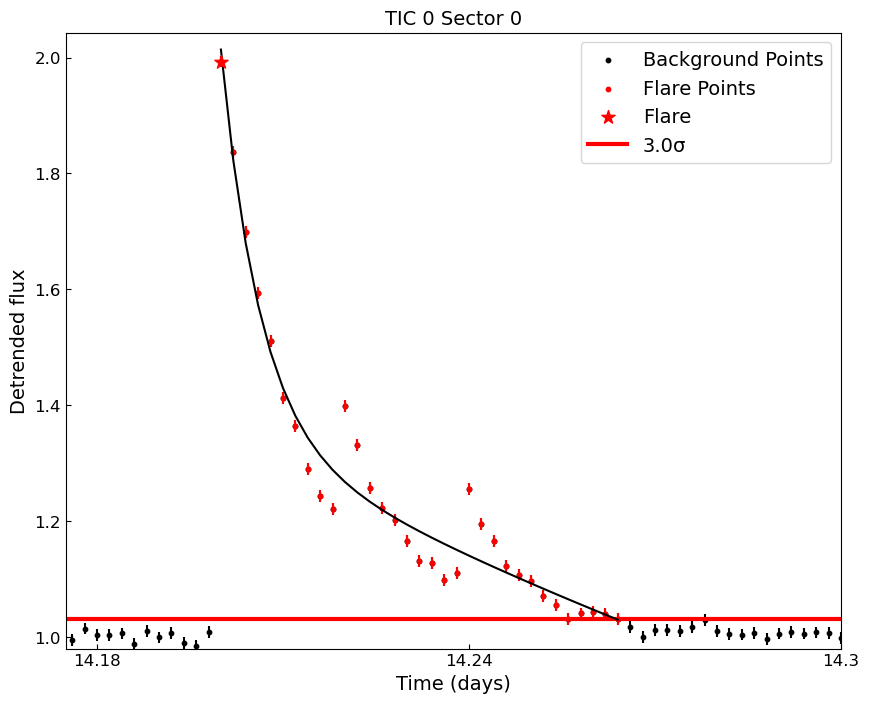

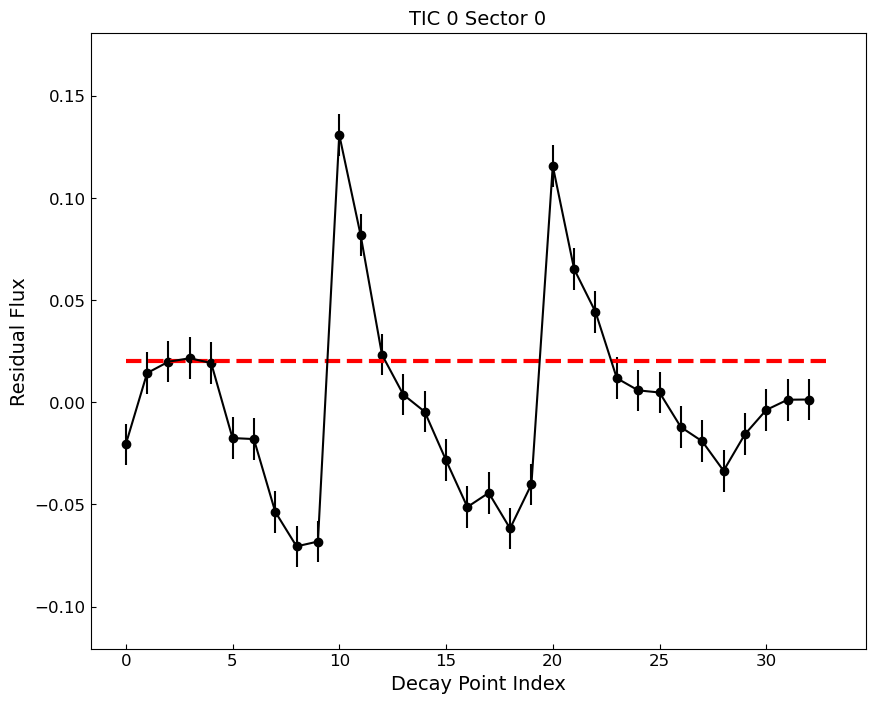

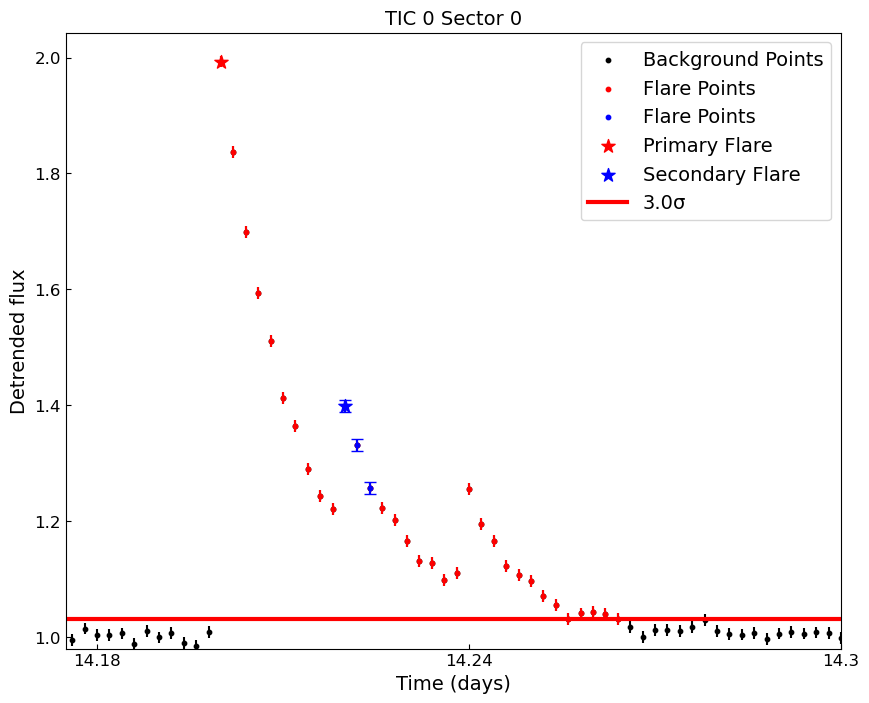

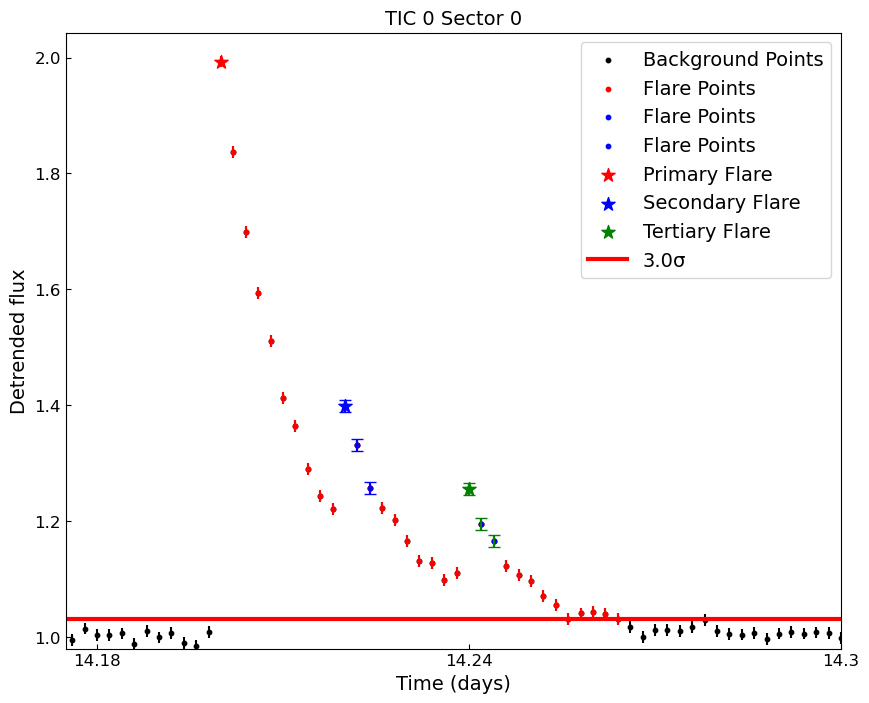

(array([14.20042004, 14.22042204, 14.24042404]),
 array([14.20042004, 14.22042204, 14.24042404]),
 array([14.26442644, 14.22442244, 14.24042404]),
 array([0.9931619 , 0.13080724, 0.1156078 ]),
 array([1374.65626423,   27.43307551,   25.06031175]),
 array(['primary', 'secondary', 'tertiary'], dtype='<U9'),
 array([32,  1,  1]),
 array([1, 1, 1]),
 array([97.60249693, 12.85501724, 11.36129953]))

In [26]:
toffee.flare_finder(time, flux, flux_err, quality, detrend = False, consecutive = True, sec_flare_std = 2.0,
                    visualize_fit = True, fit_multiple_secs = True)

## Analysis

So both the secondary and the tertiary are found!

## **Note**

By default the **fit_multiple_secs** argument is set to false. This is because in the event of Quasi-Periodic Pulsations in a flare (which are not separate flare events) TOFFEE will pick up all of them as extra flares. This could be a useful way to identify these QPPs in a large set of lightcurves but it does mean these tertiary flares may not be high quality and can be highly contaminated from QPPs.